In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
import imageio
imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

out_dir='output_images/stage2/'

# load pickled distortion matrix
with open('camera_dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]    

In [2]:
def undistort(image):
    result = cv2.undistort(image, mtx, dist, None, mtx)
    return result

def mask_image(img, s_thresh=(160, 255), sx_thresh=(15, 150),l_thresh=(20,255)):
    img = np.copy(img)
    #img = undistort_image(img)
    
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    # sobelx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255))
    # l_channel_col=np.dstack((l_channel,l_channel, l_channel))
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
            
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
        
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    color_binary = 255*np.dstack(( l_binary, sxbinary, s_binary)).astype('uint8')    
    
    combined = np.zeros_like(sxbinary)
    combined[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    color_binary_combined = 255*np.dstack(( combined, combined, combined)).astype('uint8')    
        
    return  color_binary_combined,color_binary


(720, 1280, 3)


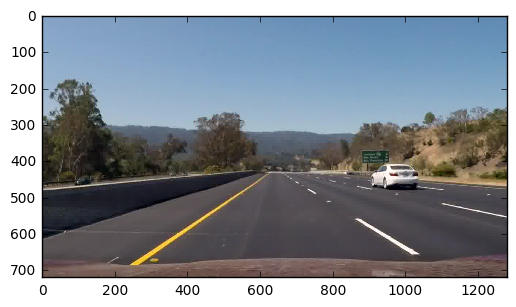

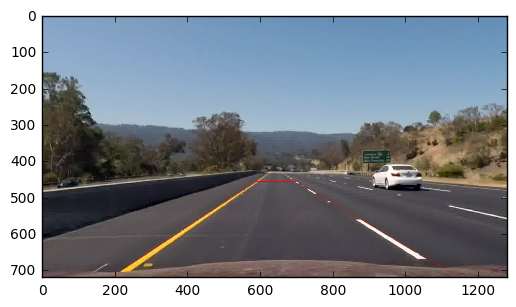

In [3]:
img=plt.imread('output_images/stage2/straight_road.jpg')
#img=plt.imread('001.jpg')
plt.figure()
plt.imshow(img)
#corners = np.float32([[231,700],[589,457],[698,457],[1095,700]])
corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])
#corners = np.float32([[190,720],[559,477],[728,477],[1145,720]])
#corners = np.float32([[210,720],[589,457],[698,457],[1145,720]])
img = cv2.undistort(img, mtx, dist, None, mtx)
imshape = img.shape
print(imshape)

corner_tuples=[]
for ind,c in enumerate(corners):
    corner_tuples.append(tuple(corners[ind]))

cv2.line(img, corner_tuples[0], corner_tuples[1], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[1], corner_tuples[2], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[2], corner_tuples[3], color=[255,0,0], thickness=1)
cv2.line(img, corner_tuples[3], corner_tuples[0], color=[255,0,0], thickness=1)
plt.figure()
plt.imshow(img)

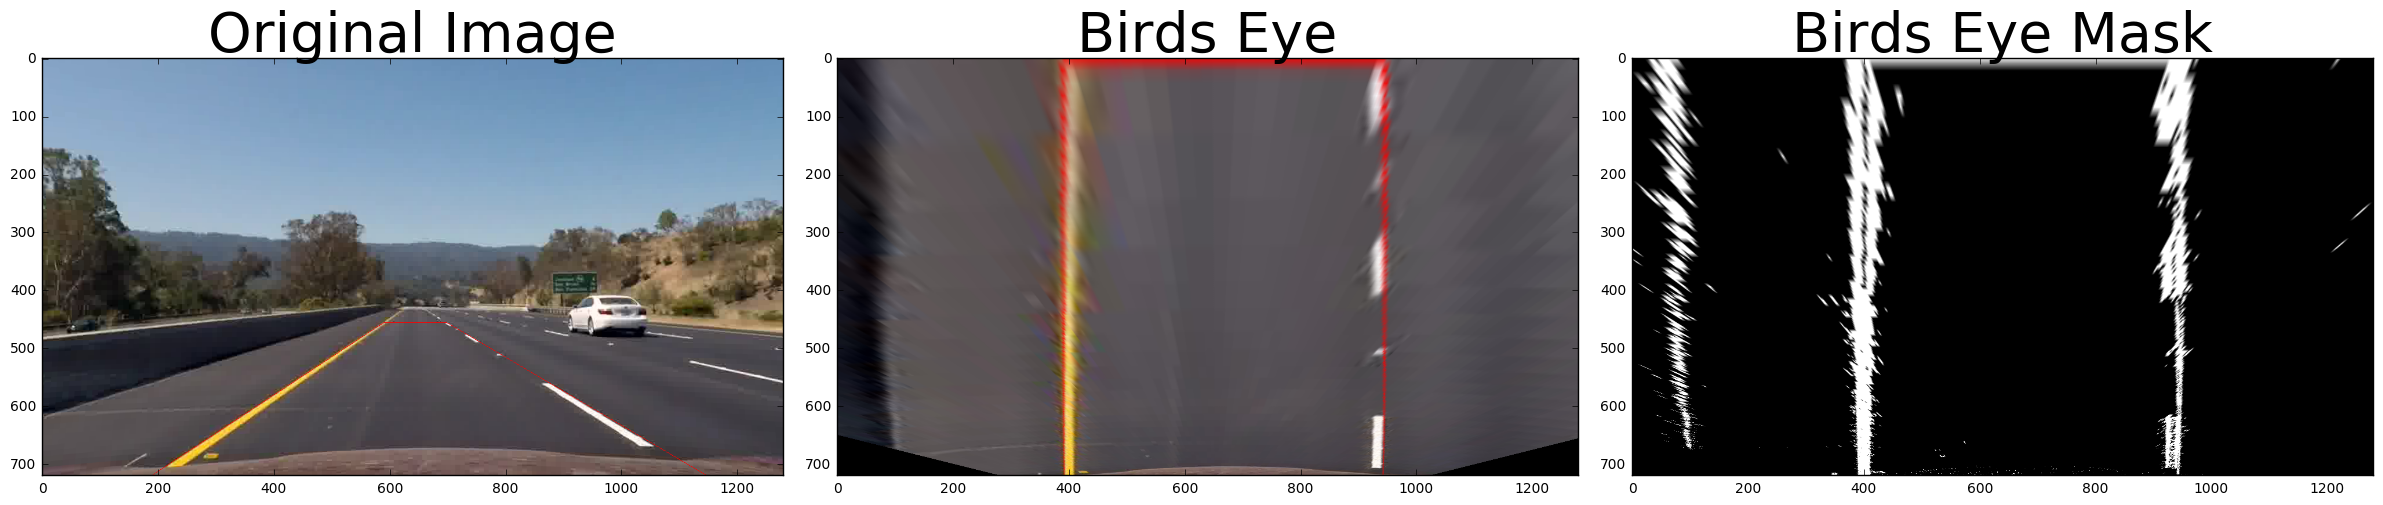

In [4]:
def warp_image(img):
    corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[200,0]
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset])    
    M = cv2.getPerspectiveTransform(src, dst)    
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped, M

def warp(image):
    undist=undistort(image)
    warped,_ = warp_image(undist)
    return warped
    
def warp_mask(image):
    undist=undistort(image)
    mask,_=mask_image(undist)
    warped,_ = warp_image(mask)
    return warped
    
birds_eye = warp(img)    
birds_eye_mask = warp_mask(img)

# Plot the result
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(birds_eye)
ax2.set_title('Birds Eye', fontsize=40)

ax3.imshow(birds_eye_mask)
ax3.set_title('Birds Eye Mask', fontsize=40)

mpimg.imsave('output_images/stage2/birds_eye.jpg',birds_eye)
mpimg.imsave('output_images/stage2/birds_eye_mask.jpg',birds_eye_mask)



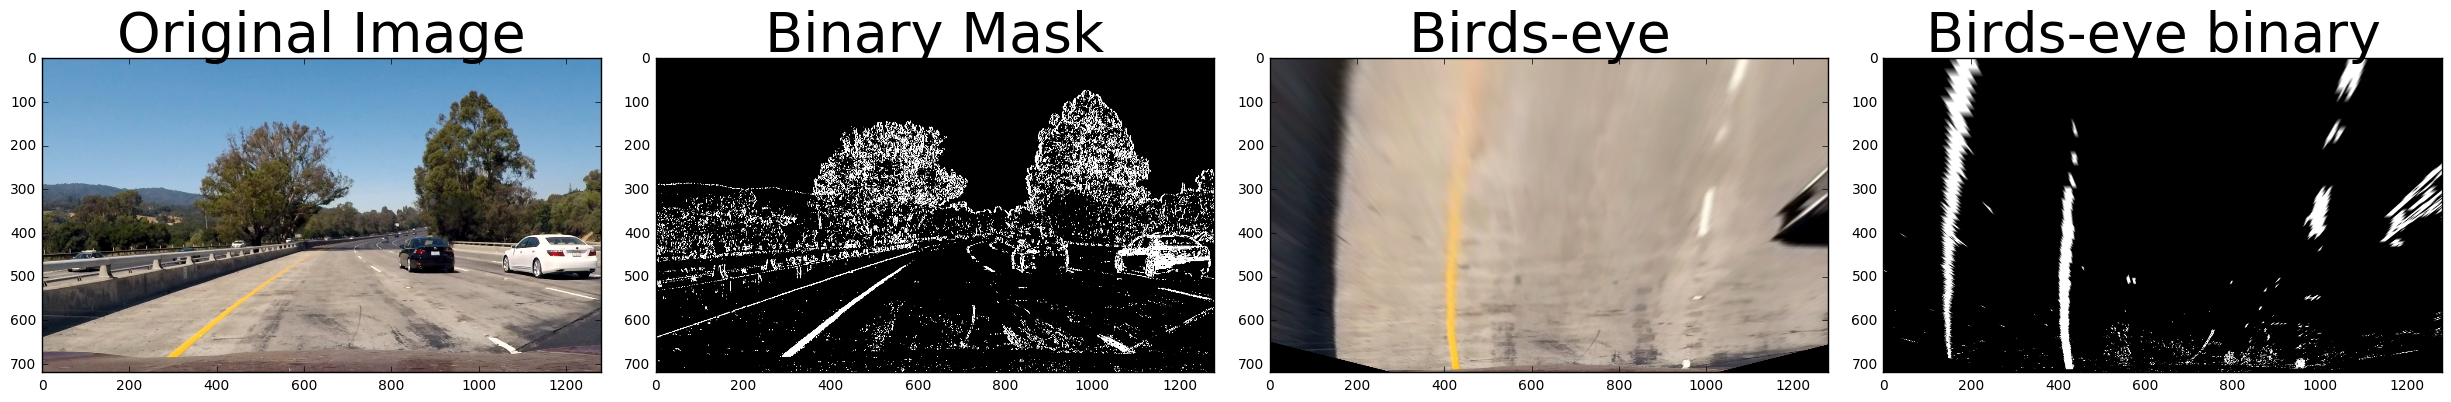

In [5]:
image  = plt.imread('test_images/test1.jpg')
birds_eye = warp(image)
mask,_ = mask_image(image)
birds_eye_mask = warp_mask(image)

# Plot the result
f, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(mask)
ax2.set_title('Binary Mask', fontsize=40)

ax3.imshow(birds_eye)
ax3.set_title('Birds-eye ', fontsize=40)

ax4.imshow(birds_eye_mask)
ax4.set_title('Birds-eye binary ', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

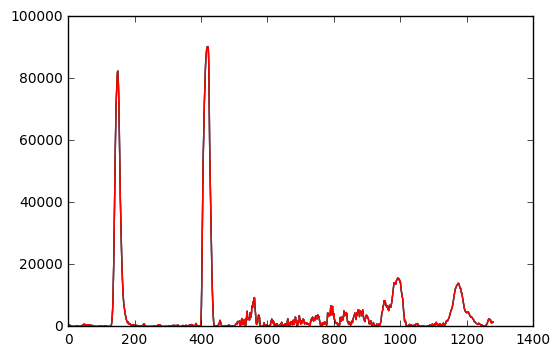

In [6]:
img=birds_eye_mask
histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
plt.plot(histogram)

In [7]:
# Step through the test images and create the binary masks
# Make a list of calibration images
images = glob.glob('test_images/*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    binary,channels = mask_image(img)    
    image_name=os.path.split(fname)[1]
    binary_name = out_dir+'binary_'+image_name
    channels_name = out_dir+'channels_'+image_name
    cv2.imwrite(binary_name,binary)
    cv2.imwrite(channels_name,channels)
    print(fname)
    cv2.imshow('binary', binary)
    cv2.waitKey(500)
cv2.destroyAllWindows()

test_images/test3.jpg
test_images/test1.jpg
test_images/test6.jpg
test_images/solidWhiteRight.jpg
test_images/solidYellowLeft.jpg
test_images/test2.jpg
test_images/test4.jpg
test_images/test5.jpg


In [122]:
def process_image(image):
    birds_eye_mask = warp_mask(image)
    return birds_eye_mask

output = out_dir+'stage2_birds_eye_mask_project_video.mp4'
clip = VideoFileClip("project_video.mp4")
binary_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time binary_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/stage2/stage2_birds_eye_mask_project_video.mp4
[MoviePy] Writing video output_images/stage2/stage2_birds_eye_mask_project_video.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 2/1261 [00:00<01:42, 12.28it/s]

  0%|          | 4/1261 [00:00<01:37, 12.83it/s]

  0%|          | 6/1261 [00:00<01:35, 13.21it/s]

  1%|          | 8/1261 [00:00<01:32, 13.48it/s]

  1%|          | 10/1261 [00:00<01:33, 13.36it/s]

  1%|          | 12/1261 [00:00<01:33, 13.30it/s]

  1%|          | 14/1261 [00:01<01:32, 13.55it/s]

  1%|▏         | 16/1261 [00:01<01:33, 13.32it/s]

  1%|▏         | 18/1261 [00:01<01:32, 13.49it/s]

  2%|▏         | 20/1261 [00:01<01:30, 13.67it/s]

  2%|▏         | 22/1261 [00:01<01:34, 13.07it/s]

  2%|▏         | 24/1261 [00:01<01:33, 13.29it/s]

  2%|▏         | 26/1261 [00:01<01:34, 13.14it/s]

  2%|▏         | 28/1261 [00:02<01:34, 13.02it/s]

  2%|▏         | 30/1261 [00:02<01:34, 13.02it/s]

  3%|▎         | 32/1261 [00:02<01:33, 13.13it/s]

  3%|▎         | 34/1261 [00:02<01:31, 13.40it/s]

  3%|▎         | 36/1261 [00:02<01:32, 13.19it/s]

  3%|▎         | 38/1261 [00:02<01:30, 13.

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/stage2/stage2_birds_eye_mask_project_video.mp4 

CPU times: user 6min 20s, sys: 1.4 s, total: 6min 21s
Wall time: 1min 38s


In [123]:
def process_image(image):
    birds_eye = warp(image)
    return birds_eye

output = out_dir+'stage2_birds_eye_project_video.mp4'
clip = VideoFileClip("project_video.mp4")
binary_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time binary_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/stage2/stage2_birds_eye_project_video.mp4
[MoviePy] Writing video output_images/stage2/stage2_birds_eye_project_video.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 3/1261 [00:00<00:47, 26.36it/s]

  0%|          | 6/1261 [00:00<00:49, 25.21it/s]

  1%|          | 9/1261 [00:00<00:50, 24.84it/s]

  1%|          | 12/1261 [00:00<00:49, 25.33it/s]

  1%|          | 15/1261 [00:00<00:50, 24.91it/s]

  1%|▏         | 18/1261 [00:00<00:49, 25.35it/s]

  2%|▏         | 21/1261 [00:00<00:49, 24.81it/s]

  2%|▏         | 24/1261 [00:00<00:48, 25.33it/s]

  2%|▏         | 27/1261 [00:01<00:47, 26.03it/s]

  2%|▏         | 30/1261 [00:01<00:46, 26.38it/s]

  3%|▎         | 33/1261 [00:01<00:46, 26.65it/s]

  3%|▎         | 36/1261 [00:01<00:46, 26.49it/s]

  3%|▎         | 39/1261 [00:01<00:45, 26.64it/s]

  3%|▎         | 42/1261 [00:01<00:46, 25.95it/s]

  4%|▎         | 45/1261 [00:01<00:50, 23.98it/s]

  4%|▍         | 48/1261 [00:01<00:51, 23.43it/s]

  4%|▍         | 51/1261 [00:02<00:52, 23.12it/s]

  4%|▍         | 54/1261 [00:02<00:54, 22.23it/s]

  5%|▍         | 57/1261 [00:02<00:56, 21

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/stage2/stage2_birds_eye_project_video.mp4 

CPU times: user 4min 8s, sys: 864 ms, total: 4min 8s
Wall time: 1min 3s


In [14]:
output = out_dir+'stage1_binary_challenge_video.mp4'
clip = VideoFileClip("challenge_video.mp4")
binary_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time binary_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/stage1/stage1_binary_challenge_video.mp4
[MoviePy] Writing video output_images/stage1/stage1_binary_challenge_video.mp4


100%|██████████| 485/485 [00:34<00:00, 14.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/stage1/stage1_binary_challenge_video.mp4 

CPU times: user 1min 43s, sys: 660 ms, total: 1min 43s
Wall time: 34.6 s
